Importer les Bibliothèques Nécessaires

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder ,StandardScaler , LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import os
import math

Lire le jeu de données et supprimer les colonnes Id, Alley et Fence, car Id n'est pas nécessaire et Alley ainsi que Fence contiennent beaucoup de valeurs manquantes et ne sont pas utiles dans le dataset, car elles n'influencent pas beaucoup le prix


In [ ]:
train = pd.read_csv("..//Housing-prices-competition//home-data-for-ml-course/train.csv")
test = pd.read_csv("..//Housing-prices-competition//home-data-for-ml-course/test.csv")
submission = pd.read_csv(".//home-data-for-ml-course/sample_submission.csv")

train.columns = train.columns.astype(str).str.strip()

test.columns = test.columns.astype(str).str.strip()

test = pd.concat([test, submission["SalePrice"]], axis=1)
data = pd.concat([train, test], ignore_index=True,axis= 0)

y_SalePrice = data['SalePrice']
data.drop("Id", axis = 1, inplace = True)
data['SalePrice'] = np.log1p(data['SalePrice'])  
data.drop("SalePrice", axis = 1, inplace = True)

data.columns = data.columns.astype(str).str.strip()





In [3]:
print("Taille de train "  , data.shape)
print("Taille de test" , data.shape)

Taille de train  (2919, 79)
Taille de test (2919, 79)


In [4]:
print("\nNombre de features de chaque type :")
print(data.dtypes.value_counts())


Nombre de features de chaque type :
object     46
int64      25
float64     8
Name: count, dtype: int64


détecter les types généraux

In [5]:
categorical_features = data.select_dtypes(include=['object']).columns
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns

print("Catégorielles :", categorical_features)
print("Numériques :", numerical_features)



Catégorielles : Index(['MSZoning', 'LotFrontage', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')
Numériques : Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath

Vérification des types de données et conversion

In [6]:
# Vérification des types de données et conversion
for column in ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']:
    data[column] = pd.to_numeric(data[column], errors='coerce')
    data[column] = pd.to_numeric(data[column], errors='coerce')

# Remplissage des valeurs manquantes
data['LotFrontage'].fillna(data['LotFrontage'].median(), inplace=True)
data['GarageYrBlt'].fillna(0, inplace=True)
data['MasVnrArea'].fillna(0, inplace=True)



/var/folders/rg/r64x99yx2k91vgyysnwnb7pc0000gn/T/ipykernel_88149/3097432669.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['LotFrontage'].fillna(data['LotFrontage'].median(), inplace=True)
/var/folders/rg/r64x99yx2k91vgyysnwnb7pc0000gn/T/ipykernel_88149/3097432669.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

les outliers 

In [ ]:
# def cap_outliers_iqr(df):
#     for column in df.select_dtypes(include=['int64', 'float64']):
#         Q1 = df[column].quantile(0.25)
#         Q3 = df[column].quantile(0.75)
#         IQR = Q3 - Q1
#         df[column] = np.clip(df[column], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
#     return df

# data = cap_outliers_iqr(data)




Création de nouvelles fonctionnalités

In [8]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression

def select_features(data, y, threshold=0.1):
    # Sélectionner uniquement les colonnes numériques
    numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
    
    # Calcul de l'information mutuelle
    mutual_infoN = mutual_info_regression(data[numerical_features].fillna(0), y, random_state=1)
    mutual_infoN = pd.Series(mutual_infoN, index=numerical_features)
    
    # Identifier les features ayant une importance inférieure au seuil
    low_mi_features = mutual_infoN[mutual_infoN < mutual_infoN.quantile(threshold)].index
    
    # Supprimer les features peu informatives
    data = data.drop(columns=low_mi_features)
    
    return data

# Application sur data
data = select_features(data, y_SalePrice)

ValueError: Found array with 0 sample(s) (shape=(0, 36)) while a minimum of 1 is required.

In [ ]:

# data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
# data['TotalBathrooms'] = data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath'])



Encoding 

In [ ]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Définition des variables ordinales et nominales
train_ordinal = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 
                 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']

train_nominal = ["MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", 
                 "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", 
                 "Heating", "CentralAir", "Electrical", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]

ordinal_mappings = {
    "LotShape": ["IR3", "IR2", "IR1", "Reg"],  # Regulier est mieux
    "Utilities": ["ELO", "NoSeWa", "NoSewr", "AllPub"],  # AllPub est le meilleur
    "LandSlope": ["Sev", "Mod", "Gtl"],  # Douce pente est meilleure
    "ExterQual": ["Po", "Fa", "TA", "Gd", "Ex"],  # Excellente qualité est la meilleure
    "ExterCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtQual": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],  # "NA" = Pas de sous-sol
    "BsmtCond": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtExposure": ["NA", "No", "Mn", "Av", "Gd"],  # Plus exposé = mieux
    "BsmtFinType1": ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],  # "GLQ" = mieux aménagé
    "BsmtFinType2": ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "HeatingQC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "KitchenQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "Functional": ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],  # Typ = Normal
    "FireplaceQu": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "GarageFinish": ["NA", "Unf", "RFn", "Fin"],  # Fin = mieux fini
    "GarageQual": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "GarageCond": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "PavedDrive": ["N", "P", "Y"],  # Y = Pavée
    "PoolQC": ["NA", "Fa", "TA", "Gd", "Ex"],  # "NA" = Pas de piscine
    "Fence": ["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"]  # GdPrv = Meilleure clôture
}

# Vérifier que les colonnes existent dans data avant transformation
ordinal_columns = [col for col in train_ordinal if col in data.columns]
nominal_columns = [col for col in train_nominal if col in data.columns]

# Encodage Ordinal
for col in ordinal_columns:
    data[col] = data[col].astype(str).str.strip().fillna("NA")

ordinal_encoder = OrdinalEncoder(categories=[ordinal_mappings[col] for col in ordinal_columns], 
                                 handle_unknown="use_encoded_value", unknown_value=-1)

data[ordinal_columns] = ordinal_encoder.fit_transform(data[ordinal_columns])

# Encodage One-Hot
#data = pd.get_dummies(data, columns=nominal_columns, dtype=int)


label_encoders = {}
for col in train_nominal:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

In [ ]:
columns_to_drop = ["GarageArea", "1stFlrSF", "TotRmsAbvGrd"]

# Vérifier si les colonnes existent avant de les supprimer
data = data.drop(columns=[col for col in columns_to_drop if col in data.columns])


print("✅ Colonnes supprimées avec succès !")

✅ Colonnes supprimées avec succès !


information mutuelle

Pourcentage de valeurs manquantes

In [ ]:
# # Imputation des valeurs manquantes en fonction du type de la colonne
# for col in data.columns:
#     if data[col].dtype in ['int64', 'float64']:  # Vérifier si c'est une colonne numérique
#         if "Bath" in col or "Cars" in col:  # Colonnes discrètes (int)
#             data[col].fillna(data[col].mode()[0], inplace=True)  # Remplir avec le mode (valeur la plus fréquente)
#         else:  
#             data[col].fillna(data[col].median(), inplace=True)  # Remplir avec la médiane pour éviter l'effet des outliers

# # Vérification après traitement
# missing_percentage = (data.isnull().sum() / len(data)) * 100
# missing_data = missing_percentage[missing_percentage > 0]

# print("Données manquantes après traitement :", missing_data)



Standardisation (scaling) avec pipeline

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Sélectionner les features numériques de data
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns

# Pipeline pour la standardisation
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Appliquer la standardisation sur les features numériques de data
data[numeric_features] = pipeline.fit_transform(data[numeric_features])




PCA

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.impute import SimpleImputer
# import pandas as pd

# def apply_pca(data):
#     # Sélection des colonnes numériques
#     numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
    
#     # Imputation des valeurs manquantes
#     imputer = SimpleImputer(strategy='mean')  # Choisir la stratégie (mean, median, most_frequent)
#     data[numerical_features] = imputer.fit_transform(data[numerical_features])
    
#     # Application de PCA pour conserver 95% de la variance
#     pca = PCA(n_components=0.95)
#     data_pca = pca.fit_transform(data[numerical_features])
    
#     # Conversion des résultats PCA en DataFrame
#     pca_columns = [f"PCA_{i+1}" for i in range(data_pca.shape[1])]
#     data_pca_df = pd.DataFrame(data_pca, columns=pca_columns)
    
#     # Mise à jour du dataset : supprimer les anciennes colonnes numériques et ajouter les nouvelles composantes PCA
#     data = data.drop(columns=numerical_features).reset_index(drop=True)
    
#     # Concaténer les résultats PCA au dataset
#     data = pd.concat([data, data_pca_df], axis=1)
    
#     return data

# # Appliquer PCA à la variable `data` (combinaison de train et test)
# data = apply_pca(data)


La coorelation

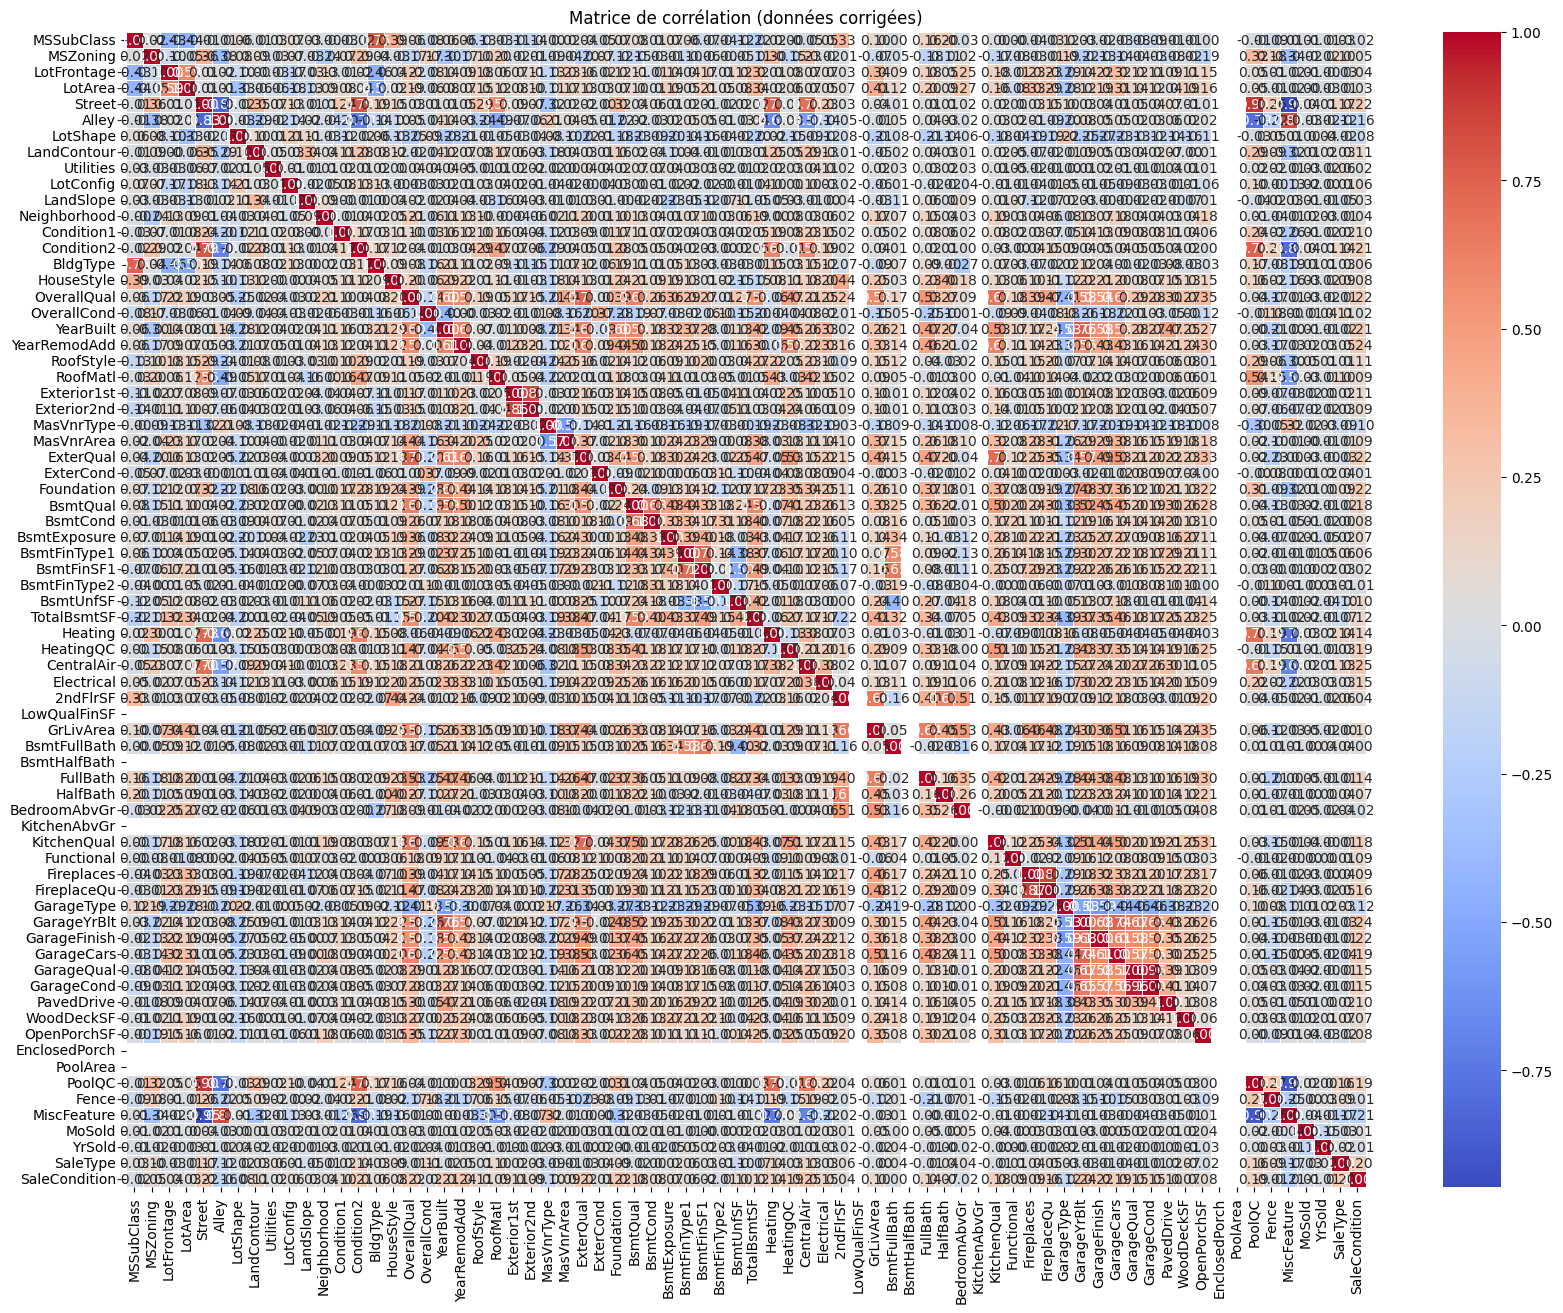

In [ ]:
numeric_data = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de corrélation (données corrigées)')
plt.show()

  dropping features

In [ ]:
data.fillna("NA", inplace=True)


/var/folders/rg/r64x99yx2k91vgyysnwnb7pc0000gn/T/ipykernel_81659/1838996397.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.fillna("NA", inplace=True)


 Encoding des Features Ordinales et nominals

In [ ]:
from sklearn.preprocessing import PowerTransformer

# Sélectionner les colonnes numériques
numeric_value = data.select_dtypes(include=['float64', 'int64'])

# Calculer la skewness pour chaque feature numérique
skewness = numeric_value.apply(lambda x: x.skew()).sort_values(ascending=False)

# Définir un seuil de skewness
skew_threshold = 0.75

# Sélectionner les features fortement biaisées
highly_skewed = skewness[skewness > skew_threshold].index
print(f"🔍 Found {len(highly_skewed)} highly skewed features:\n", skewness[highly_skewed])

# Appliquer la transformation Yeo-Johnson
pt = PowerTransformer(method="yeo-johnson")
data[highly_skewed] = pt.fit_transform(data[highly_skewed])

print("✅ Yeo-Johnson transformation applied successfully!")


🔍 Found 17 highly skewed features:
 RoofMatl        5.347616
Heating         3.572536
BsmtFinType2    2.803922
Condition1      2.664186
BldgType        2.063957
Condition2      1.549818
RoofStyle       1.368658
Fence           1.346778
ExterCond       1.316590
MasVnrArea      1.309944
OpenPorchSF     1.161260
PoolQC          1.096312
WoodDeckSF      1.093418
MSSubClass      0.995762
BsmtExposure    0.914673
2ndFlrSF        0.847174
ExterQual       0.786786
dtype: float64
✅ Yeo-Johnson transformation applied successfully!


In [ ]:
new_skewness = data[highly_skewed].apply(lambda x: x.skew())
print("📉 Skewness after transformation:\n", new_skewness)


📉 Skewness after transformation:
 RoofMatl        0.252863
Heating         0.270944
BsmtFinType2   -1.383135
Condition1     -0.396790
BldgType        0.423668
Condition2     -0.022811
RoofStyle      -0.009982
Fence           0.263750
ExterCond      -1.060570
MasVnrArea      0.658330
OpenPorchSF     0.330871
PoolQC          0.241278
WoodDeckSF      0.390848
MSSubClass      0.209610
BsmtExposure   -0.397502
2ndFlrSF        0.423177
ExterQual      -0.150847
dtype: float64


final Data

In [ ]:



# Diviser les données en train et test
tra = data.iloc[:1460, :]  # 1460 premières lignes pour l'entraînement
tes = data.iloc[1460:, :]  # Le reste pour le test

# Extraire SalePrice pour l'entraînement (pour concaténer avec les features d'entraînement)
y_S = y_SalePrice.iloc[:1460]  # Pas besoin de `:` supplémentaire ici

# Ajouter y_SalePrice à `tra` (en tant que nouvelle colonne)
tra = pd.concat([tra, y_S], axis=1)

# Vérifier la forme des ensembles train et test
print(tra.shape, tes.shape)

# Sauvegarder les fichiers résultants
tra.to_csv('final_data.csv', index=False)
tes.to_csv('final_test_data.csv', index=False)


(1460, 73) (1459, 72)
